<a href="https://colab.research.google.com/github/tatiana-ka/exploring-scraped-data-imdb/blob/main/Scraping20YearsIMDb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Scraping 20 years of IMDb movies**

In this notebook I am scaping 20 years (1999-2019) of movie data from IMDb. The goal for me was two-fold. First, I have a bigger project idea that would require some somewhat objective infromation about movie quality. Second, I wanted to get back into scraping and play around with it. 



In this notebook I explore scraping step by step. First, applying scraping just for one page to make sure I extract all the information from html nicely. I also find it helpful to progress step by step wrapping more and more code around like matroshka. This way it goes faster when I have to get into code after a long break. Second, I try to optimize and automate scaping to get all 20 years in one dataset. 

I play with loops and functions to make the code more efficient. Still, there are quite a few things that can be improved (some I note in the comments to the code). Like with many things in life, things get clearer in retrospective, so some improvements are left for the next time. 

In [1]:
from requests import get
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from time import sleep
from random import randint
from datetime import datetime
from IPython.core.display import clear_output
from warnings import warn
import math

Connect to the google drive. This will come in handy when I’ll start loading the scraped data. 

In [2]:
from google.colab import files, drive

drive.mount('/content/drive')

Mounted at /content/drive


### **Working on one page**

Both because some things I learn as I go, and because it’s nice to have the logic parsed I start by working with the html from just one page before getting full on into scraping. 
First examining this page: 
https://www.imdb.com/search/title/?title_type=feature&release_date=1999-01-01,2019-12-31&languages=en&count=250&start=1&ref_=adv_nxt

The page is already set up so that:
* it's only feature films;
* only between 1999 and 2019 (inclusive)
* language - English
* number of movies per page = 250

Looking at the link it is fairly easy to see where this information pops up. Once I know the structure of the link, I can edit it. This way, for example, I can edit the link to jump to the next 250 movies, see *start=251* within the link below. Notice, in the link above *start=1*.

https://www.imdb.com/search/title/?title_type=feature&release_date=1999-01-01,2019-12-31&languages=en&count=250&start=251&ref_=adv_nxt

**Calling the page**

In [ ]:
url = 'https://www.imdb.com/search/title/?title_type=feature&release_date=1999-01-01,2019-12-31&languages=en&count=250&start=1&ref_=adv_nxt'

response = get(url)

print(response.text[:500])



<!DOCTYPE html>
<html
    xmlns:og="http://ogp.me/ns#"
    xmlns:fb="http://www.facebook.com/2008/fbml">
    <head>
         

        <meta charset="utf-8">
        <meta http-equiv="X-UA-Compatible" content="IE=edge">




        <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:'java'};</script>

<script>
    if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
</script>
  <script>(function(t){ (t.events = t.events || {})["csm_head_pre_


**Parcing HTML**

In [ ]:
html_soup = BeautifulSoup(response.text, 'html.parser') #changes type to BeautifulSoup

In [ ]:
movie_containers = html_soup.find_all('div', class_ = 'lister-item mode-advanced')

print(len(movie_containers)) # N containers

250


I have 250 containers, that's good, so I managed to get 250 movies from the page. 

These are the items that I would like to get from the page: 
* Title
* IMDb ID 
* Duration
* Genre
* IMDb rating
* Metascore
* Synopsys
* Votes 
* Gross

Starting with the first movie:

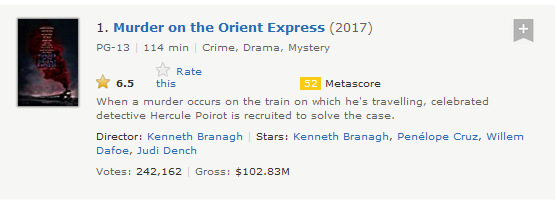

#### **For one movie**

Here is what I have if I call html that refers to the first movie.
The 6th line says "Murder on the Orient Express" among other things, so it seems I'm on the right spot. 

In [ ]:
first_movie = movie_containers[0]

first_movie

<div class="lister-item mode-advanced">
<div class="lister-top-right">
<div class="ribbonize" data-caller="filmosearch" data-tconst="tt3402236"></div>
</div>
<div class="lister-item-image float-left">
<a href="/title/tt3402236/"> <img alt="Murder on the Orient Express" class="loadlate" data-tconst="tt3402236" height="98" loadlate="https://m.media-amazon.com/images/M/MV5BMTAxNDkxODIyMDZeQTJeQWpwZ15BbWU4MDQ2Mjg4NDIy._V1_UX67_CR0,0,67,98_AL_.jpg" src="https://m.media-amazon.com/images/S/sash/4FyxwxECzL-U1J8.png" width="67"/>
</a> </div>
<div class="lister-item-content">
<h3 class="lister-item-header">
<span class="lister-item-index unbold text-primary">1.</span>
<a href="/title/tt3402236/">Murder on the Orient Express</a>
<span class="lister-item-year text-muted unbold">(2017)</span>
</h3>
<p class="text-muted ">
<span class="certificate">PG-13</span>
<span class="ghost">|</span>
<span class="runtime">114 min</span>
<span class="ghost">|</span>
<span class="genre">
Crime, Drama, Mystery  

Calling the Movie Name

In [ ]:
first_movie.h3.a # that's too much, need to get the text only

<a href="/title/tt3402236/">Murder on the Orient Express</a>

In [ ]:
first_movie.h3.a.text

'Murder on the Orient Express'

Calling Movie ID

In [ ]:
first_movie.div.div['data-tconst']

'tt3402236'

Calling Duration

In [ ]:
first_movie.find('span', class_ = 'runtime').text

'114 min'

Calling Genre

In [ ]:
first_movie.find('span', class_ = 'genre').text

'\nCrime, Drama, Mystery            '

Calling IMDb Rating

In [ ]:
first_movie.strong.text

'6.5'

Calling Metascore

In [ ]:
first_movie.find('span', class_ = 'metascore').text 

'52        '

Need to be careful about some missing data here: not all movies have Metascore. For example, 5th movie on the page does not have it. 

In [ ]:
movie_containers[5].find('span', class_ = 'metascore').text #if error

AttributeError: ignored

Wrapping in `try` to pass the error:

In [ ]:
try:
  test1 = movie_containers[5].find('span', class_ = 'metascore').text
except:
  print(None)  

None


Calling Synopsis

In [ ]:
first_movie.find_all('p', class_ = 'text-muted')[1].text

"\nWhen a murder occurs on the train on which he's travelling, celebrated detective Hercule Poirot is recruited to solve the case."

Calling N Votes

In [ ]:
first_movie.find('span', attrs = {'name':'nv'})['data-value']

'242162'

Calling Gross

In [ ]:
first_movie.find_all('span', attrs = {'name':'nv'})[1]['data-value']

'102,826,543'

Again, need to be careful about missing data: movie 5 has no Gross.

In [ ]:
print(movie_containers[5].find_all('span', attrs = {'name':'nv'})[1]['data-value']) #if error - None

IndexError: ignored

In [ ]:
try:
  test = movie_containers[5].find_all('span', attrs = {'name':'nv'})[1]['data-value']
except:
  print(None)  


None


#### **For the whole page**

Now that I've seen how to get each variable I want for one movie, I will put it together, to get these items for all the movies on the page. 

I will creat an empty list for each variable. I will fill this list with the data from the movies. 

In [ ]:
#lists for data

title = []
imbdID = []
duration = []
genre = []
imdb_rating = []
metascore = []
synopsys = []
votes = []
gross = []

In [ ]:
for container in movie_containers:
  title.append(container.h3.a.text) #title
  imbdID.append(container.div.div['data-tconst'])#imdb ID
  
  try:
    duration.append(container.find('span', class_ = 'runtime').text) #duration
  except:
    duration.append(None) 

  try:
    genre.append(container.find('span', class_ = 'genre').text) #genre
  except:
    genre.append(None)

  imdb_rating.append(container.strong.text)  #imdb rating

  try:
    metascore.append(container.find('span', class_ = 'metascore').text) #metascore
  except:
    metascore.append(None)

  try:
    synopsys.append(container.find_all('p', class_ = 'text-muted')[1].text)  #synopsys
  except:
    synopsys.append(None)

  votes.append(container.find('span', attrs = {'name':'nv'})['data-value'])  #votes

  try:
    gross.append(container.find_all('span', attrs = {'name':'nv'})[1]['data-value']) #gross
  except:
    gross.append(None)  


In [ ]:
page1_df = pd.DataFrame({
    'title': title,
    'imdbID': imbdID,
    'duration': duration,
    'genre': genre,
    'imdb_rating': imdb_rating,
    'metascore': metascore,
    'synopsys': synopsys,
    'votes': votes,
    'gross': gross
})

In [ ]:
page1_df.head(20)

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross
0,Murder on the Orient Express,tt3402236,114 min,"\nCrime, Drama, Mystery",6.5,52,\nWhen a murder occurs on the train on which h...,242162,"102,826,543"
1,Fantastic Beasts: The Crimes of Grindelwald,tt4123430,134 min,"\nAdventure, Family, Fantasy",6.5,52,"\nThe second installment of the ""Fantastic Bea...",256942,"159,555,901"
2,The Dark Knight,tt0468569,152 min,"\nAction, Crime, Drama",9.1,84,\nWhen the menace known as the Joker wreaks ha...,2538189,"534,858,444"
3,Fantastic Beasts and Where to Find Them,tt3183660,132 min,"\nAdventure, Family, Fantasy",7.3,66,\nThe adventures of writer Newt Scamander in N...,449358,"234,037,575"
4,Blade Runner 2049,tt1856101,164 min,"\nAction, Drama, Mystery",8.0,81,\nYoung Blade Runner K's discovery of a long-b...,535240,"92,054,159"
5,Batman v Superman: Dawn of Justice Ultimate Ed...,tt18689424,182 min,"\nAction, Adventure, Sci-Fi",8.0,None,\nBatman is manipulated by Lex Luthor to fear ...,15286,None
6,Avengers: Endgame,tt4154796,181 min,"\nAction, Adventure, Drama",8.4,78,\nAfter the devastating events of Avengers: In...,1037024,"858,373,000"
7,Harry Potter and the Sorcerer's Stone,tt0241527,152 min,"\nAdventure, Family, Fantasy",7.6,65,\nAn orphaned boy enrolls in a school of wizar...,747568,"317,575,550"
8,Interstellar,tt0816692,169 min,"\nAdventure, Drama, Sci-Fi",8.7,74,\nA team of explorers travel through a wormhol...,1716149,"188,020,017"
9,The Wolf of Wall Street,tt0993846,180 min,"\nBiography, Comedy, Crime",8.2,75,"\nBased on the true story of Jordan Belfort, f...",1331738,"116,900,694"


In [ ]:
page1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        250 non-null    object
 1   imdbID       250 non-null    object
 2   duration     250 non-null    object
 3   genre        250 non-null    object
 4   imdb_rating  250 non-null    object
 5   metascore    247 non-null    object
 6   synopsys     250 non-null    object
 7   votes        250 non-null    object
 8   gross        238 non-null    object
dtypes: object(9)
memory usage: 17.7+ KB


### **Creating the loop for multiple pages**

If I want to scrape multiple pages, I will be sending a lot of requests to IMDb. So there is a good chance that soon enough they will ban me for that. 
To prevent that from happening, I need to introduce sleep time between my call requests. I'm sure the people at IMDB are smart, and will be able to catch me even with the sleep times if i am not careful. I don't want to be banned, and I am not in a hurry, so to solve this, I will be generous with the sleep time. 

First just goling to platy around with the sleep time to see how it works and what it does. 

In [ ]:
sleep_time = []

for _ in range(100):
  sleep_time.append(randint(20, 300))

In [ ]:
sleep_time = np.array(sleep_time)

In [ ]:
np.mean(sleep_time)

168.23

In [ ]:
import matplotlib.pyplot as plt

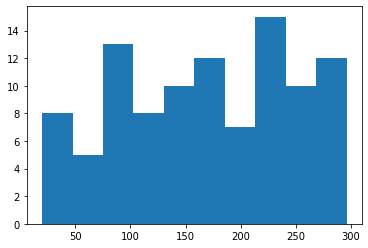

In [ ]:
plt.hist(sleep_time)
plt.show()

I need to call in every next page with new 250 movies. That means that I need to be changing the *start=* part of the link: e.g. *start = 1, start = 251, start = 501, etc.*.

Like this: 
https://www.imdb.com/search/title/?title_type=feature&release_date=1999-01-01,2019-12-31&languages=en&count=250&start=1&ref_=adv_nxt

https://www.imdb.com/search/title/?title_type=feature&release_date=1999-01-01,2019-12-31&languages=en&count=250&start=251&ref_=adv_nxt

https://www.imdb.com/search/title/?title_type=feature&release_date=1999-01-01,2019-12-31&languages=en&count=250&start=501&ref_=adv_nxt

For this I will first create a list of values for start. 
I will start with a list for the first 50 links. With the sleep time included that already will take a while to collect. I'm working in a free version of Google Colab which means that at some point the notebook will terminate. Therefore, I should not run the code that will take longer than the notebook will stay active. 

In [ ]:
start = [1]

for i in range(50):
  if i == 1:
    print('first')
  else:
    start.append((start[i-1] + 250))


first


In [ ]:
start[49]

12251

In [ ]:
len(start) #got 50 starting pints

50

Actions:
1.  I first create an empty list for each variable. 
2. I create an outer loop that generates a new link for the page that should be requested.
3. Go to sleep.
4. Call the page. 
5. Parse the content and feed it into the lists

In [ ]:
#creating empty lists for each variable
title = []
imbdID = []
duration = []
genre = []
imdb_rating = []
metascore = []
synopsys = []
votes = []
gross = []

In [ ]:
requests = 0
time1 = datetime.now()

for start_number in start:
  #request
  response = get('https://www.imdb.com/search/title/?title_type=feature&release_date=1999-01-01,2019-12-31&languages=en&count=250&start=' + str(start_number) + '&ref_=adv_nxt')

  
  #break time
  requests += 1 #which request
  sleep(randint(20, 420)) #make a pause
  elapsed_time = datetime.now() - time1 #what was the length of the pause
  print('Request: {}; Sleep time: {} second(s)'.format(requests, elapsed_time.seconds))
  time1 = datetime.now() #reset loop counter to start now
  
  clear_output(wait = True) # clean out the output after each iteration


  page_html = BeautifulSoup(response.text, 'html.parser')

  movie_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced') # create movie containers


  for container in movie_containers:
    title.append(container.h3.a.text) #title
    imbdID.append(container.div.div['data-tconst'])#imdb ID
  
    try:
      duration.append(container.find('span', class_ = 'runtime').text) #duration
    except:
      duration.append(None) 

    try:
      genre.append(container.find('span', class_ = 'genre').text) #genre
    except:
      genre.append(None)

    imdb_rating.append(container.strong.text)  #imdb rating

    try:
      metascore.append(container.find('span', class_ = 'metascore').text) #metascore
    except:
      metascore.append(None)

    try:
      synopsys.append(container.find_all('p', class_ = 'text-muted')[1].text)  #synopsys
    except:
      synopsys.append(None)

    votes.append(container.find('span', attrs = {'name':'nv'})['data-value'])  #votes

    try:
      gross.append(container.find_all('span', attrs = {'name':'nv'})[1]['data-value']) #gross
    except:
      gross.append(None)  



KeyboardInterrupt: ignored

It seems that the scraper crashed after 37 pages for not finding imdb rating of a movie. The way I collect now, i cannot skip over the error if title, ID, rating or votes information is missing. It seems that it crashed because there was no rating information. Will add missing values and put together into the dataframe what I have collected for now. 

In [ ]:
first50_df = pd.DataFrame({
    'title': title,
    'imdbID': imbdID,
    'duration': duration,
    'genre': genre,
    'imdb_rating': imdb_rating,
    'metascore': metascore,
    'synopsys': synopsys,
    'votes': votes,
    'gross': gross
})

In [ ]:
imdb_rating.append(None)

In [ ]:
metascore.append(None)

In [ ]:
synopsys.append(None)

In [ ]:
votes.append(None)

In [ ]:
gross.append(None)

In [ ]:
len(synopsys)

9317

In [ ]:
len(votes)

9317

In [ ]:
9317/250

37.268

So i have managed 37 full pages and a bit of 36th

In [ ]:
print(len(title))
print(len(imbdID))
print(len(duration))
print(len(genre))
print(len(imdb_rating))
print(len(metascore))
print(len(synopsys))
print(len(votes))
print(len(gross))

9318
9318
9318
9318
9318
9318
9318
9318
9318


In [ ]:
first50_df.tail(20)

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross
9298,Don Peyote,tt1828968,98 min,"\nComedy, Drama",3.6,14,"\nDON PEYOTE tells the story Warren Allman, an...",880,None
9299,Lymelife,tt0363780,95 min,"\nComedy, Drama, Romance",6.9,64,\nA family unit begins to bow under the pressu...,14094,"429,307"
9300,Mohawk,tt5189828,91 min,"\nAction, Drama, History",4.6,70,"\nLate in the War of 1812, a young Mohawk woma...",1475,None
9301,Lonesome Jim,tt0385056,91 min,"\nComedy, Drama",6.6,54,"\nFailing to make it on his own, twenty-seven-...",7797,"154,077"
9302,Girl Fever,tt0265010,98 min,"\nComedy, Romance",5.0,None,\nSam is a dexterity-challenged art student ha...,2503,None
9303,Happily Ever After,tt0381270,100 min,"\nComedy, Drama, Music",6.5,58,\nIs the love compatible with coupledom? And w...,4968,"252,341"
9304,Columbus Circle,tt1465533,82 min,"\nCrime, Drama, Mystery",6.0,None,\nAn heiress who's been shut inside her apartm...,10539,None
9305,Awakening the Zodiac,tt6294892,100 min,"\nCrime, Drama, Mystery",4.8,None,\nOver 40 years since the infamous Zodiac kill...,1961,None
9306,Blood Orange,tt4145108,85 min,\nThriller,4.3,None,"\nBlood Orange stars Iggy Pop as Bill, an agei...",806,None
9307,Trois,tt0217107,93 min,"\nDrama, Romance, Thriller",4.0,None,\nTrouble erupts when a happily married couple...,646,"1,160,268"


**Saving the intermit result**

In [ ]:
first50_df.to_csv('first50_df.csv')

!cp first50_df.csv "/content/drive/MyDrive/movies_scraped"

In [ ]:
first50_df = pd.read_csv('/content/drive/MyDrive/movies_scraped/first50_df.csv')

In [ ]:
first50_df.tail()

,Unnamed: 0,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross
9313,9313,Chloe & Theo,tt1754736,81 min,"\nComedy, Drama",5.9,24.0,\nFrom the northern ice comes a gentler kind o...,1576.0,NaN
9314,9314,Crazy,tt0443474,106 min,"\nBiography, Drama, Music",6.5,NaN,"\nInspired by the life of Hank Garland, CRAZY ...",670.0,NaN
9315,9315,Loco Love,tt0293452,94 min,"\nComedy, Romance",5.3,26.0,"\nAfter losing his restaurant to his ex-wife, ...",583.0,NaN
9316,9316,I Hate Valentine's Day,tt0762105,98 min,"\nComedy, Romance",4.7,17.0,"\nA florist, who abides by a strict five-date-...",8403.0,"10,060"
9317,9317,Sunshine of Your Love: A Concert for Jack Bruce,tt8232576,120 min,\nMusic,NaN,NaN,NaN,NaN,NaN


In [ ]:
start[37]

9251

In [ ]:
start[37:50]

[9251,
 9501,
 9751,
 10001,
 10251,
 10501,
 10751,
 11001,
 11251,
 11501,
 11751,
 12001,
 12251]

In [ ]:
first50_df.head()

,Unnamed: 0,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross
0,0,Suicide Squad,tt1386697,123 min,"\nAction, Adventure, Fantasy",5.9,40.0,\nA secret government agency recruits some of ...,640035.0,"325,100,054"
1,1,Midsommar,tt8772262,148 min,"\nDrama, Horror, Mystery",7.1,72.0,\nA couple travels to Scandinavia to visit a r...,244466.0,"27,331,977"
2,2,Once Upon a Time... In Hollywood,tt7131622,161 min,"\nComedy, Drama",7.6,83.0,\nA faded television actor and his stunt doubl...,622443.0,"142,502,728"
3,3,Don't Breathe,tt4160708,88 min,"\nCrime, Horror, Thriller",7.1,71.0,"\nHoping to walk away with a massive fortune, ...",240946.0,"89,217,875"
4,4,The Losers,tt0480255,97 min,"\nAction, Adventure, Crime",6.3,44.0,\nA CIA special forces team is betrayed and le...,95954.0,"23,580,735"


In [ ]:
len(first50_df.loc[:9250])

9251

In [ ]:
9251/250

37.004

**Saving for 37 full pages**

To scrape by full pages in this first chunk I'll save only full 37 pages that I have collected and continue with 38th.

In [ ]:
first50_df['order_movie_count'] = first50_df['Unnamed: 0'] + 1

In [ ]:
first37_df = first50_df[first50_df.order_movie_count <9251].copy()

In [ ]:
first37_df.to_csv('first37_df.csv')

!cp first37_df.csv "/content/drive/MyDrive/movies_scraped"

### **Creating a function for scraping**

To make the process more efficient, I will wrap the code above into a function. 
Because of the limitation of running time for the free Colab version, I also should chunk my requests so that I don't try to call too many movies in one go. If I do that the notebook will stop working before I manage to save what I've collected. Another reason is because after 9999 movies the link changes its format. 
I chunk by number of movies rather than by even time periods because the number of movies produced in a year increases as I get closer to now. 
This way I end up with 11 batches. With the generous sleep time it takes quite a while to collect that. I was casually running batches of code below over a couple of days always saving the dataframe for each batch separately (if I had to do it again I would include the saving part of the code in the function). 



The function that takes the imdb link chuncked in 3 pieses, start year and end year. Pools title, imdbID, duration, genre, imdb rating, metascore, synopsys, votes and gross from those pages and forms into a data frame. The final result is data frame. The selected time range should not include more than 9999 titles. After 9999 titles, imdb link changes. 


* The finction prints number of requests it is going to make and estimated time for completion.
* The finction prints "Let's roll!", just because. 
* The function prints an error message and breaks if it cannot get a requested page.
* The function prints sleep time after request X. Only last request is always printed (previously printed information is cleared). This way there is not too much text and I know what is going on now when I check in on the code. 
* The function pauses the requests, introducing random sleep time between 20 and 420 secons. 


In [ ]:
def scrape_250_pages(year_start, year_end, link1, link2, link3):
  title = []
  imbdID = []
  duration = []
  genre = []
  imdb_rating = []
  metascore = []
  synopsys = []
  votes = []
  gross = []
  year = []

  #defining the number of titles
  response = get(link1 + str(year_start) + '-01-01,' + str(year_end) + link2 + str(1) + link3, headers = {"Accept-Language": "en-US, en;q=0.5"})
  page_html = BeautifulSoup(response.text, 'html.parser')

  n_titles = re.findall(r'\d+,\d+', page_html.find('div', class_ = 'desc').span.text)[0]
  n_titles = int(re.sub(r',', '', n_titles))

  #defining the list of start pages
  start = [1]
  n_pages = math.ceil(n_titles/250)# divide number of titles by 250 and round up to integer

  print('Will make ' + str(n_pages) + ' requests')
  print('Estimated time for completion is ' + str(math.ceil(218.5*n_pages/60)) + ' minutes')
  
  for i in range(n_pages):
    if i == 1:
      print('Lets Roll!')
    else:
      start.append((start[i-1] + 250))

  requests = 0
  time1 = datetime.now()

  for start_number in start:
  #request
    try:
      response = get(link1 + str(year_start) + '-01-01,' + str(year_end) + link2 + str(start_number) + link3, headers = {"Accept-Language": "en-US, en;q=0.5"}) #to get english language titles use headers argument
    except:
      print('ERROR!!!: Cannot get the response from IMDb')

      break  

  
    #break time
    requests += 1 #which request
    sleep(randint(20, 420)) #make a pause between 20 seconds and 7 minutes
    elapsed_time = datetime.now() - time1 #what was the length of the pause
    print('Request: {}; Sleep time: {} second(s)'.format(requests, elapsed_time.seconds))
    time1 = datetime.now() #reset loop counter to start now
  
    clear_output(wait = True) # clean out the output after each iteration


    page_html = BeautifulSoup(response.text, 'html.parser')

    movie_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced') # create movie containers


    for container in movie_containers:
      title.append(container.h3.a.text) #title
      imbdID.append(container.div.div['data-tconst'])#imdb ID
  
      try:
        duration.append(container.find('span', class_ = 'runtime').text) #duration
      except:
        duration.append(None) 

      try:
        genre.append(container.find('span', class_ = 'genre').text) #genre
      except:
        genre.append(None)

      try:
        imdb_rating.append(container.strong.text)  #imdb rating
      except:
        imdb_rating.append(None)  

      try:
        metascore.append(container.find('span', class_ = 'metascore').text) #metascore
      except:
        metascore.append(None)

      try:
        synopsys.append(container.find_all('p', class_ = 'text-muted')[1].text)  #synopsys
      except:
        synopsys.append(None)

      try:
        votes.append(container.find('span', attrs = {'name':'nv'})['data-value'])  #votes
      except:
        votes.append(None)

      try:
        gross.append(container.find_all('span', attrs = {'name':'nv'})[1]['data-value']) #gross
      except:
        gross.append(None)

      try:
        year.append(container.h3.find('span', class_ = 'lister-item-year text-muted unbold')) #year
      except:
        year.append(None)



  df = pd.DataFrame({
      'title': title,
      'imdbID': imbdID,
      'duration': duration,
      'genre': genre,
      'imdb_rating': imdb_rating,
      'metascore': metascore,
      'synopsys': synopsys,
      'votes': votes,
      'gross': gross,
      'year': year
  })
  
  print('Number of movies retrieved: ' + str(n_titles))

  return df        

**Applying the function**

In [ ]:
#'https://www.imdb.com/search/title/?title_type=feature&release_date=1999-01-01,2019-12-31&languages=en&count=250&start=1&ref_=adv_nxt'

link1 = 'https://www.imdb.com/search/title/?title_type=feature&release_date='
link2 = '-12-31&languages=en&count=250&start='
link3 = '&ref_=adv_nxt'

In [ ]:
#split so that no group is exceeding 9999 titles if exceding the link is different
start_year = [1999, 2004, 2008, 2010, 2012, 2014, 2015, 2016, 2017, 2018, 2019]
finish_year = [2003, 2007, 2009, 2011, 2013, 2014, 2015, 2016, 2017, 2018, 2019]



1.   1999-2003 = 8173 titles
2.   2004-2007 = 9210 titles
3.   2008-2009 = 6939 titles
4.   2010-2011 = 8193 titles 
5.   2012-2013 = 9500 titles 
6.   2014-2014 = 5063 titles 
7.   2015-2015 = 5258 titles 
8.   2016-2016 = 5637 titles 
9.   2017-2017 = 6152 titles 
10.   2018-2018 = 6168 titles 
11.   2019-2019 = 5357 titles 



**First Batch**: 1999-2003

In [ ]:
y_99_03_df = scrape_250_pages(year_start = start_year[0], year_end = finish_year[0], link1 = link1, link2 = link2, link3 = link3)

Number of movies retrieved: 8172


In [ ]:
y_99_03_df.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
0,Harry Potter and the Sorcerer's Stone,tt0241527,152 min,"\nAdventure, Family, Fantasy",7.6,64,\nAn orphaned boy enrolls in a school of wizar...,693017,"317,575,550",[(2001)]
1,The Lord of the Rings: The Fellowship of the Ring,tt0120737,178 min,"\nAction, Adventure, Drama",8.8,92,\nA meek Hobbit from the Shire and eight compa...,1721432,"315,544,750",[(2001)]
2,The Matrix,tt0133093,136 min,"\nAction, Sci-Fi",8.7,73,\nWhen a beautiful stranger leads computer hac...,1741678,"171,479,930",[(1999)]
3,Fight Club,tt0137523,139 min,\nDrama,8.8,66,\nAn insomniac office worker and a devil-may-c...,1928126,"37,030,102",[(1999)]
4,Catch Me If You Can,tt0264464,141 min,"\nBiography, Crime, Drama",8.1,75,"\nBarely 21 yet, Frank is a skilled forger who...",877182,"164,615,351",[(2002)]


In [ ]:
len(y_99_03_df)

8172

In [ ]:
y_99_03_df.to_csv('y_99_03_df.csv') #save the subset

!cp y_99_03_df.csv "/content/drive/MyDrive/movies_scraped"

**Second Batch: 2004-2007**

In [ ]:
y_04_07_df = scrape_250_pages(year_start = start_year[1], year_end = finish_year[1], link1 = link1, link2 = link2, link3 = link3)

Number of movies retrieved: 9210


In [ ]:
len(y_04_07_df)

9210

In [ ]:
y_04_07_df.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
0,Superbad,tt0829482,113 min,\nComedy,7.6,76,\nTwo co-dependent high school seniors are for...,539621,"121,463,226",[(2007)]
1,The Departed,tt0407887,151 min,"\nCrime, Drama, Thriller",8.5,85,\nAn undercover cop and a mole in the police a...,1233359,"132,384,315",[(2006)]
2,Munich,tt0408306,164 min,"\nAction, Drama, History",7.5,74,\nBased on the true story of the Black Septemb...,217982,"47,403,685",[(2005)]
3,No Country for Old Men,tt0477348,122 min,"\nCrime, Drama, Thriller",8.1,91,\nViolence and mayhem ensue after a hunter stu...,894447,"74,283,625",[(2007)]
4,Death Proof,tt1028528,127 min,"\nAction, Adventure, Thriller",7.0,None,\nTwo separate sets of voluptuous women are st...,277514,None,[(2007)]


In [ ]:
y_04_07_df.to_csv('y_04_07_df.csv') #save the subset

!cp y_04_07_df.csv "/content/drive/MyDrive/movies_scraped"

**Third Batch: 2008-2009**

In [ ]:
start_year[2]

2008

In [ ]:
finish_year[2]

2009

In [ ]:
y_08_09_df = scrape_250_pages(year_start = start_year[2], year_end = finish_year[2], link1 = link1, link2 = link2, link3 = link3)

Number of movies retrieved: 6939


In [ ]:
len(y_08_09_df)

6939

In [ ]:
y_08_09_df.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
0,The Dark Knight,tt0468569,152 min,"\nAction, Crime, Drama",9.0,84,\nWhen the menace known as the Joker wreaks ha...,2402742,"534,858,444",[(2008)]
1,Twilight,tt1099212,122 min,"\nDrama, Fantasy, Romance",5.2,56,\nWhen Bella Swan moves to a small town in the...,440871,"191,465,414",[(I) (2008)]
2,Inglourious Basterds,tt0361748,153 min,"\nAdventure, Drama, War",8.3,69,"\nIn Nazi-occupied France during World War II,...",1323494,"120,540,719",[(2009)]
3,Star Trek,tt0796366,127 min,"\nAction, Adventure, Sci-Fi",7.9,82,\nThe brash James T. Kirk tries to live up to ...,588022,"257,730,019",[(2009)]
4,Watchmen,tt0409459,162 min,"\nAction, Drama, Mystery",7.6,56,"\nIn 1985 where former superheroes exist, the ...",523804,"107,509,799",[(2009)]


In [ ]:
y_08_09_df.to_csv('y_08_09_df.csv') #save the subset

!cp y_08_09_df.csv "/content/drive/MyDrive/movies_scraped"

**Fourth Batch: 2010-2011**

In [ ]:
start_year[3]

2010

In [ ]:
finish_year[3]

2011

In [ ]:
y_10_11_df = scrape_250_pages(year_start = start_year[3], year_end = finish_year[3], link1 = link1, link2 = link2, link3 = link3)

Number of movies retrieved: 8194


In [ ]:
len(y_10_11_df)

8194

In [ ]:
y_10_11_df.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
0,The Losers,tt0480255,97 min,"\nAction, Adventure, Crime",6.3,44,\nA CIA special forces team is betrayed and le...,96095,"23,580,735",[(I) (2010)]
1,Inception,tt1375666,148 min,"\nAction, Adventure, Sci-Fi",8.8,74,\nA thief who steals corporate secrets through...,2155408,"292,576,195",[(2010)]
2,Captain America: The First Avenger,tt0458339,124 min,"\nAction, Adventure, Sci-Fi",6.9,66,"\nSteve Rogers, a rejected military soldier, t...",777067,"176,654,505",[(2011)]
3,Shutter Island,tt1130884,138 min,"\nMystery, Thriller",8.2,63,"\nIn 1954, a U.S. Marshal investigates the dis...",1186486,"128,012,934",[(2010)]
4,Harry Potter and the Deathly Hallows: Part 2,tt1201607,130 min,"\nAdventure, Drama, Fantasy",8.1,85,"\nHarry, Ron, and Hermione search for Voldemor...",797408,"381,011,219",[(2011)]


In [ ]:
y_10_11_df.to_csv('y_10_11_df.csv') #save the subset

!cp y_10_11_df.csv "/content/drive/MyDrive/movies_scraped"

**Fifth Batch:2012-2013**

In [ ]:
start_year[4]

2012

In [ ]:
finish_year[4]

2013

In [ ]:
y_12_13_df = scrape_250_pages(year_start = start_year[4], year_end = finish_year[4], link1 = link1, link2 = link2, link3 = link3)

Number of movies retrieved: 9500


In [ ]:
len(y_12_13_df)

9500

In [ ]:
y_12_13_df.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
0,The Wolf of Wall Street,tt0993846,180 min,"\nBiography, Crime, Drama",8.2,75,"\nBased on the true story of Jordan Belfort, f...",1253070,"116,900,694",[(2013)]
1,Django Unchained,tt1853728,165 min,"\nDrama, Western",8.4,81,"\nWith the help of a German bounty-hunter, a f...",1416504,"162,805,434",[(2012)]
2,The Great Gatsby,tt1343092,143 min,"\nDrama, Romance",7.2,55,"\nA writer and wall street trader, Nick, finds...",499179,"144,840,419",[(2013)]
3,Prisoners,tt1392214,153 min,"\nCrime, Drama, Mystery",8.1,70,\nWhen Keller Dover's daughter and her friend ...,631577,"61,002,302",[(2013)]
4,The Dark Knight Rises,tt1345836,164 min,"\nAction, Adventure",8.4,78,\nEight years after the Joker's reign of anarc...,1569233,"448,139,099",[(2012)]


In [ ]:
y_12_13_df.to_csv('y_12_13_df.csv') #save the subset

!cp y_12_13_df.csv "/content/drive/MyDrive/movies_scraped"

**Sixth Batch: 2014-2014**

In [ ]:
start_year[5]

2014

In [ ]:
finish_year[5]

2014

In [ ]:
y_14_14_df = scrape_250_pages(year_start = start_year[5], year_end = finish_year[5], link1 = link1, link2 = link2, link3 = link3)

Number of movies retrieved: 5063


In [ ]:
len(y_14_14_df)

5063

In [ ]:
y_14_14_df.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
0,Guardians of the Galaxy,tt2015381,121 min,"\nAction, Adventure, Comedy",8.0,76,\nA group of intergalactic criminals must pull...,1085795,"333,176,600",[(2014)]
1,Interstellar,tt0816692,169 min,"\nAdventure, Drama, Sci-Fi",8.6,74,\nA team of explorers travel through a wormhol...,1599799,"188,020,017",[(2014)]
2,John Wick,tt2911666,101 min,"\nAction, Crime, Thriller",7.4,68,\nAn ex-hit-man comes out of retirement to tra...,571253,"43,037,835",[(2014)]
3,Gone Girl,tt2267998,149 min,"\nDrama, Mystery, Thriller",8.1,79,\nWith his wife's disappearance having become ...,900711,"167,767,189",[(2014)]
4,Kingsman: The Secret Service,tt2802144,129 min,"\nAction, Adventure, Comedy",7.7,60,\nA spy organisation recruits a promising stre...,612521,"128,261,724",[(2014)]


In [ ]:
y_14_14_df.to_csv('y_14_14_df.csv') #save the subset

!cp y_14_14_df.csv "/content/drive/MyDrive/movies_scraped"

**Seventh Batch: 2015**

In [ ]:
start_year[6]

2015

In [ ]:
finish_year[6]

2015

In [ ]:
y_15_15_df = scrape_250_pages(year_start = start_year[6], year_end = finish_year[6], link1 = link1, link2 = link2, link3 = link3)

Number of movies retrieved: 5258


In [ ]:
len(y_15_15_df)

5258

In [ ]:
y_15_15_df.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
0,Love,tt3774694,135 min,"\nDrama, Romance",6.1,51,\nMurphy is an American living in Paris who en...,52566,None,[(II) (2015)]
1,Mad Max: Fury Road,tt1392190,120 min,"\nAction, Adventure, Sci-Fi",8.1,90,"\nIn a post-apocalyptic wasteland, a woman reb...",920886,"154,058,340",[(2015)]
2,Fifty Shades of Grey,tt2322441,125 min,"\nDrama, Romance, Thriller",4.1,46,\nLiterature student Anastasia Steele's life c...,305526,"166,167,230",[(2015)]
3,Sicario,tt3397884,121 min,"\nAction, Crime, Drama",7.6,82,\nAn idealistic FBI agent is enlisted by a gov...,390263,"46,889,293",[(2015)]
4,The Hateful Eight,tt3460252,168 min,"\nCrime, Drama, Mystery",7.8,68,"\nIn the dead of a Wyoming winter, a bounty hu...",546010,"54,117,416",[(2015)]


In [ ]:
y_15_15_df.to_csv('y_15_15_df.csv') #save the subset

!cp y_15_15_df.csv "/content/drive/MyDrive/movies_scraped"

**Eighth Batch: 2016**

In [ ]:
start_year[7]

2016

In [ ]:
finish_year[7]

2016

In [ ]:
y_16_16_df = scrape_250_pages(year_start = start_year[7], year_end = finish_year[7], link1 = link1, link2 = link2, link3 = link3)

Number of movies retrieved: 5638


In [ ]:
len(y_16_16_df)

5637

In [ ]:
y_16_16_df.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
0,Suicide Squad,tt1386697,123 min,"\nAction, Adventure, Fantasy",5.9,40,\nA secret government agency recruits some of ...,641029,"325,100,054",[(2016)]
1,Don't Breathe,tt4160708,88 min,"\nCrime, Horror, Thriller",7.1,71,"\nHoping to walk away with a massive fortune, ...",241398,"89,217,875",[(2016)]
2,Deadpool,tt1431045,108 min,"\nAction, Adventure, Comedy",8.0,65,\nA wisecracking mercenary gets experimented o...,941597,"363,070,709",[(2016)]
3,The Magnificent Seven,tt2404435,132 min,"\nAction, Adventure, Western",6.9,54,\nSeven gunmen from a variety of backgrounds a...,197190,"93,432,655",[(2016)]
4,Moana,tt3521164,107 min,"\nAnimation, Adventure, Comedy",7.6,81,"\nIn Ancient Polynesia, when a terrible curse ...",293666,"248,757,044",[(I) (2016)]


In [ ]:
y_16_16_df.to_csv('y_16_16_df.csv') #save the subset

!cp y_16_16_df.csv "/content/drive/MyDrive/movies_scraped"

**Nineth Batch: 2017**

In [ ]:
start_year[8]

2017

In [ ]:
finish_year[8]

2017

In [ ]:
y_17_17_df = scrape_250_pages(year_start = start_year[8], year_end = finish_year[8], link1 = link1, link2 = link2, link3 = link3)

Will make 25 requests
Estimated time for completion is 92 minutes
Lets Roll!
Request: 1; Sleep time: 139 second(s)
Request: 2; Sleep time: 150 second(s)
Request: 3; Sleep time: 194 second(s)
Request: 4; Sleep time: 205 second(s)
Request: 5; Sleep time: 273 second(s)
Request: 6; Sleep time: 382 second(s)
Request: 7; Sleep time: 393 second(s)
Request: 8; Sleep time: 334 second(s)
Request: 9; Sleep time: 425 second(s)
Request: 10; Sleep time: 146 second(s)
Request: 11; Sleep time: 202 second(s)
Request: 12; Sleep time: 194 second(s)
Request: 13; Sleep time: 209 second(s)
Request: 14; Sleep time: 249 second(s)
Request: 15; Sleep time: 208 second(s)
Request: 16; Sleep time: 223 second(s)
Request: 17; Sleep time: 307 second(s)
Request: 18; Sleep time: 101 second(s)
Request: 19; Sleep time: 50 second(s)
Request: 20; Sleep time: 252 second(s)
Request: 21; Sleep time: 384 second(s)
Request: 22; Sleep time: 65 second(s)
Request: 23; Sleep time: 286 second(s)
Request: 24; Sleep time: 396 second(s

In [ ]:
len(y_17_17_df)

6152

In [ ]:
y_17_17_df.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
0,Guardians of the Galaxy Vol. 2,tt3896198,136 min,"\nAction, Adventure, Comedy",7.6,67,\nThe Guardians struggle to keep together as a...,604920,"389,813,101",[(2017)]
1,Thor: Ragnarok,tt3501632,130 min,"\nAction, Adventure, Comedy",7.9,74,"\nImprisoned on the planet Sakaar, Thor must r...",639493,"315,058,289",[(2017)]
2,Blade Runner 2049,tt1856101,164 min,"\nAction, Drama, Mystery",8.0,81,\nYoung Blade Runner K's discovery of a long-b...,493033,"92,054,159",[(2017)]
3,The Greatest Showman,tt1485796,105 min,"\nBiography, Drama, Musical",7.6,48,\nCelebrates the birth of show business and te...,253549,"174,340,174",[(2017)]
4,The Hitman's Bodyguard,tt1959563,118 min,"\nAction, Comedy, Crime",6.9,47,"\nThe world's top bodyguard gets a new client,...",208930,"75,468,583",[(2017)]


In [ ]:
y_17_17_df.to_csv('y_17_17_df.csv') #save the subset

!cp y_17_17_df.csv "/content/drive/MyDrive/movies_scraped"

**Tenth Batch: 2018**

In [ ]:
start_year[9]

2018

In [ ]:
finish_year[9]

2018

In [ ]:
y_18_18_df = scrape_250_pages(year_start = start_year[9], year_end = finish_year[9], link1 = link1, link2 = link2, link3 = link3)

Number of movies retrieved: 6166


In [ ]:
len(y_18_18_df)

6166

In [ ]:
y_18_18_df.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
0,The Kissing Booth,tt3799232,105 min,"\nComedy, Romance",6.0,None,\nA high school student is forced to confront ...,74627,None,[(2018)]
1,A Quiet Place,tt6644200,90 min,"\nDrama, Horror, Sci-Fi",7.5,82,"\nIn a post-apocalyptic world, a family is for...",474381,"188,024,361",[(2018)]
2,Venom,tt1270797,112 min,"\nAction, Adventure, Sci-Fi",6.7,35,\nA failed reporter is bonded to an alien enti...,396537,"213,515,506",[(2018)]
3,Hereditary,tt7784604,127 min,"\nDrama, Horror, Mystery",7.3,87,\nA grieving family is haunted by tragic and d...,264612,"44,069,456",[(2018)]
4,Avengers: Infinity War,tt4154756,149 min,"\nAction, Adventure, Sci-Fi",8.4,68,\nThe Avengers and their allies must be willin...,913921,"678,815,482",[(2018)]


In [ ]:
y_18_18_df.to_csv('y_18_18_df.csv') #save the subset

!cp y_18_18_df.csv "/content/drive/MyDrive/movies_scraped"

**Eleventh Batch: 2019**

In [ ]:
start_year[10]

2019

In [ ]:
finish_year[10]

2019

In [ ]:
y_19_19_df = scrape_250_pages(year_start = start_year[10], year_end = finish_year[10], link1 = link1, link2 = link2, link3 = link3)

Number of movies retrieved: 5356


In [ ]:
len(y_19_19_df)

5356

In [ ]:
y_19_19_df.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
0,Midsommar,tt8772262,148 min,"\nDrama, Horror, Mystery",7.1,72,\nA couple travels to Scandinavia to visit a r...,246130,"27,331,977",[(2019)]
1,Once Upon a Time... In Hollywood,tt7131622,161 min,"\nComedy, Drama",7.6,83,\nA faded television actor and his stunt doubl...,624991,"142,502,728",[(2019)]
2,Avengers: Endgame,tt4154796,181 min,"\nAction, Adventure, Drama",8.4,78,\nAfter the devastating events of Avengers: In...,925917,"858,373,000",[(2019)]
3,Joker,tt7286456,122 min,"\nCrime, Drama, Thriller",8.4,59,"\nIn Gotham City, mentally troubled comedian A...",1052123,"335,451,311",[(2019)]
4,Knives Out,tt8946378,130 min,"\nComedy, Crime, Drama",7.9,82,\nA detective investigates the death of a patr...,516601,"165,359,751",[(2019)]


In [ ]:
y_19_19_df.to_csv('y_19_19_df.csv') #save the subset

!cp y_19_19_df.csv "/content/drive/MyDrive/movies_scraped"

Uhy! Now I have collected information for movies over 20-year period!

### **Merging the chuncks together**

Now that I have all the 20 years of the movie data, I need to put them in one dataframe. 
Another point for code optimization would have been to concatenate the newly-scraped data and the excisting (already scraped) one before saving every time I ran the scraping function. 
Since I did not think about this in advance, now I ended up with 11 dataframes that I need to put into one. 

In [ ]:
file_names = ['y_99_03_df', 'y_04_07_df', 'y_08_09_df', 'y_10_11_df', 'y_12_13_df', 'y_14_14_df', 'y_15_15_df', 'y_16_16_df', 'y_17_17_df', 'y_18_18_df', 'y_19_19_df']

imdb_scraped = pd.DataFrame()
for name in file_names:
  full_name = '/content/drive/MyDrive/movies_scraped/' + name + '.csv'
  loaded_df = pd.read_csv(full_name)
  imdb_scraped = pd.concat([imdb_scraped, loaded_df]).reset_index(drop = True)


In [ ]:
len(imdb_scraped )

75647

Just a quick check to see if my barched approach did not result in some duplicates. It seems all is well and all the movie IDs are unique. 

In [ ]:
imdb_scraped.imdbID.is_unique

True

In [ ]:
imdb_scraped.head()

,Unnamed: 0,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
0,0,Harry Potter and the Sorcerer's Stone,tt0241527,152 min,"\nAdventure, Family, Fantasy",7.6,64.0,\nAn orphaned boy enrolls in a school of wizar...,693017,"317,575,550","<span class=""lister-item-year text-muted unbol..."
1,1,The Lord of the Rings: The Fellowship of the Ring,tt0120737,178 min,"\nAction, Adventure, Drama",8.8,92.0,\nA meek Hobbit from the Shire and eight compa...,1721432,"315,544,750","<span class=""lister-item-year text-muted unbol..."
2,2,The Matrix,tt0133093,136 min,"\nAction, Sci-Fi",8.7,73.0,\nWhen a beautiful stranger leads computer hac...,1741678,"171,479,930","<span class=""lister-item-year text-muted unbol..."
3,3,Fight Club,tt0137523,139 min,\nDrama,8.8,66.0,\nAn insomniac office worker and a devil-may-c...,1928126,"37,030,102","<span class=""lister-item-year text-muted unbol..."
4,4,Catch Me If You Can,tt0264464,141 min,"\nBiography, Crime, Drama",8.1,75.0,"\nBarely 21 yet, Frank is a skilled forger who...",877182,"164,615,351","<span class=""lister-item-year text-muted unbol..."


### **Cleaning**

Now I need to clean up the data a little bit. 
* I'm going to clean up and extract the **year**, because it seems that part of the code did not wokr well and I still have a chunk of html in my year column; 
* Drop the unnamed column that is really df's index before saving the csv;
* Check and explore missing values, decide if it's worth keeping them;
* Clean up the genre and create some dummies for it;
* Check and allign data types so that they can be easily analyzable.

**Cleaning Year**

Using reguilar expression extracting 4 consequtive number from the chunk of hgtm code that is year, then stripping white spaces. 

In [ ]:
imdb_scraped['year'] = imdb_scraped.year.str.extract('(\d{4})', expand = False).str.strip()

**Dropping index Column**

In [ ]:
imdb_scraped = imdb_scraped.drop(columns='Unnamed: 0')

**Exploring what I have up to now:**

In [ ]:
imdb_scraped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75647 entries, 0 to 75646
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        75647 non-null  object 
 1   imdbID       75647 non-null  object 
 2   duration     62437 non-null  object 
 3   genre        72241 non-null  object 
 4   imdb_rating  51444 non-null  float64
 5   metascore    8924 non-null   float64
 6   synopsys     75647 non-null  object 
 7   votes        51471 non-null  object 
 8   gross        7211 non-null   object 
 9   year         75557 non-null  object 
dtypes: float64(2), object(8)
memory usage: 5.8+ MB


In [ ]:
imdb_scraped.isna().sum()

title              0
imdbID             0
duration       13210
genre           3406
imdb_rating    24203
metascore      66723
synopsys           0
votes          24176
gross          68436
year              90
dtype: int64

In [ ]:
imdb_scraped.isna().sum()/len(imdb_scraped)

title          0.000000
imdbID         0.000000
duration       0.174627
genre          0.045025
imdb_rating    0.319947
metascore      0.882031
synopsys       0.000000
votes          0.319590
gross          0.904676
year           0.001190
dtype: float64

In [ ]:
len(imdb_scraped) - imdb_scraped.isna().sum()

title          75647
imdbID         75647
duration       62437
genre          72241
imdb_rating    51444
metascore       8924
synopsys       75647
votes          51471
gross           7211
year           75557
dtype: int64

**Important points:**
* Only have 7211 movies with Gross
* Only have 8924 movies with metascore
* 24203 movies are missing IMDb rating - definitely drop those
* 24176 number of movies do not have votes - seems close to the number of those without IMDB rating, will check again after deleting those if any left
* 90 movies are missing year, but we know the range.
* All movies have synopsys, title and IMDb ID
* Votes, gross and year need to be converted into the appropriate formats
* Duration - remove minutes and convert to appropriate format



**Drop movies with no IMDb Rating**

In [ ]:
imdb_rated = imdb_scraped.dropna(subset=['imdb_rating']).copy().reset_index(drop = True)

In [ ]:
imdb_rated.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
0,Harry Potter and the Sorcerer's Stone,tt0241527,152 min,"\nAdventure, Family, Fantasy",7.6,64.0,\nAn orphaned boy enrolls in a school of wizar...,693017,"317,575,550",2001
1,The Lord of the Rings: The Fellowship of the Ring,tt0120737,178 min,"\nAction, Adventure, Drama",8.8,92.0,\nA meek Hobbit from the Shire and eight compa...,1721432,"315,544,750",2001
2,The Matrix,tt0133093,136 min,"\nAction, Sci-Fi",8.7,73.0,\nWhen a beautiful stranger leads computer hac...,1741678,"171,479,930",1999
3,Fight Club,tt0137523,139 min,\nDrama,8.8,66.0,\nAn insomniac office worker and a devil-may-c...,1928126,"37,030,102",1999
4,Catch Me If You Can,tt0264464,141 min,"\nBiography, Crime, Drama",8.1,75.0,"\nBarely 21 yet, Frank is a skilled forger who...",877182,"164,615,351",2002


**Checking some rare missing values**

In [ ]:
imdb_rated.isna().sum()

title              0
imdbID             0
duration        3949
genre            867
imdb_rating        0
metascore      42523
synopsys           0
votes              1
gross          44233
year               4
dtype: int64

After deleting movies without imdb rating, it seems tha there is only one movie with no votes data. After checking it seems that this movie actually has 8 votes. Not sure why those did not record, but since it's only one, I can add it manually. 

*Votes*

In [ ]:
imdb_rated[imdb_rated.votes.isna()] 

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
23133,Believe: The Misfit Pawn,tt1972602,90 min,\nDrama,8.3,NaN,"\n We award this movie five Doves, our best ra...",NaN,NaN,2011


In [ ]:
imdb_rated[['votes']] = imdb_rated[['votes']].fillna(8)

*Year*

4 movies do not have a year information. After manual check, the look a bit odd. Since it's only 4 and they are odd, will just drop them. 

In [ ]:
imdb_rated[imdb_rated.year.isna()] # some odd movies. It would be easier to search plot movie name + year, so drop those

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year
28337,Tied in Blood,tt1027755,88 min,"\nDrama, Horror, Mystery",3.5,NaN,"\nGeorge, convinced a ghost killed his family,...",222,NaN,NaN
47873,Vanity Fear,tt7424940,NaN,\nHorror,3.8,NaN,"\nMike, a struggling actor from LA, craves fam...",6,NaN,NaN
48237,As Words Breathe,tt2368535,80 min,\nDrama,7.9,NaN,\nAfter resigning her career path oriented ban...,19,NaN,NaN
50306,Cool as Hell 2,tt6745192,90 min,\nComedy,6.2,NaN,\nAfter goofball Rich accidentally decapitates...,19,NaN,NaN


In [ ]:
imdb_rated = imdb_rated.dropna(subset=['year']).reset_index(drop = True)

**Working with Genre**

Genre needs some work before turning it into dummies.
* need to remove white spaces;
* drop commas in case of multiple genre;
* get info on all unique genres;
* create a dummy variable for each genre.

In [ ]:
imdb_rated['genre'] = imdb_rated.genre.str.strip()# remove white spaces

In [ ]:
imdb_rated['genre'] = imdb_rated.genre.str.replace(',', '') #remove comas (there is a space between too, so the words won't be collapsed together)

In [ ]:
imdb_rated['list_genre'] = imdb_rated.genre.str.split() #make into lists

In [ ]:
genre_only = imdb_rated[['list_genre', 'imdb_rating']].copy() #sebset into a copy df

The following code:
1. gets a list of lists for genres out of the data
2. flattens the list
3. gets unique genres and counts 

In [ ]:
genre_raw  = list(imdb_rated[imdb_rated.genre.notna()].list_genre) # need to drop NaNs first, because otherwise the for-loop crushes

#getting the fpatlist of genres
genre_flat = [] 
for sub in genre_raw:
  for g in sub:
    genre_flat.append(g)


genre_flat = np.array(genre_flat)
genre, count = np.unique(genre_flat, return_counts = True)

genre_summary = pd.DataFrame({'genre': genre,
                              'count': count})

genre_summary = genre_summary.sort_values(by = ['count'], ascending = False)
genre_summary

,genre,count
6,Drama,25768
4,Comedy,15545
21,Thriller,8765
11,Horror,8699
0,Action,6718
17,Romance,5932
5,Crime,5067
1,Adventure,3579
14,Mystery,3288
18,Sci-Fi,2632


The last 4 genres are very rare, so it's not worth to use them for creating a column. 

In [ ]:
print(genre_summary.genre[:-4]) #those make into a column

genres_key = list(genre_summary.genre[:-4])

6         Drama
4        Comedy
21     Thriller
11       Horror
0        Action
17      Romance
5         Crime
1     Adventure
14      Mystery
18       Sci-Fi
7        Family
8       Fantasy
2     Animation
3     Biography
12        Music
10      History
19        Sport
13      Musical
22          War
23      Western
Name: genre, dtype: object


Now will create a dummy variable for the each of the 20 genres. 
The code does the following:
For each of the 20 genre, 
  1. create a list where the dummy would feed. 
  2. For each line in imdb_rated dataset first check if the genre is known.
  3. If genre not known, fill with None
  4. If the genre is known, check whether this movie is of the focal genre (another rason why list format for this is convinient, besides flattening and getting unique genres).  
  5. If genre matches, record as 1, if not as 0. 

Once through all rows add the new dummy variable column to the dable named as genre and move to the next.   

In [ ]:
for gen in genres_key:
  x = [] #feeding dummies this list before including it in df

  for i in range(len(imdb_rated)):
    if type(imdb_rated.list_genre[i]) == float: #if no genre info available
      x.append(None)
    else:  
      if gen in imdb_rated.list_genre[i]: #if genre found
        x.append(1) 
      else: #if genre not found
        x.append(0)  

  imdb_rated[gen] = x #add the dummy column in the df

In [ ]:
imdb_rated.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year,...,Family,Fantasy,Animation,Biography,Music,History,Sport,Musical,War,Western
0,Harry Potter and the Sorcerer's Stone,tt0241527,152 min,Adventure Family Fantasy,7.6,64.0,\nAn orphaned boy enrolls in a school of wizar...,693017,"317,575,550",2001,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Lord of the Rings: The Fellowship of the Ring,tt0120737,178 min,Action Adventure Drama,8.8,92.0,\nA meek Hobbit from the Shire and eight compa...,1721432,"315,544,750",2001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Matrix,tt0133093,136 min,Action Sci-Fi,8.7,73.0,\nWhen a beautiful stranger leads computer hac...,1741678,"171,479,930",1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Fight Club,tt0137523,139 min,Drama,8.8,66.0,\nAn insomniac office worker and a devil-may-c...,1928126,"37,030,102",1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Catch Me If You Can,tt0264464,141 min,Biography Crime Drama,8.1,75.0,"\nBarely 21 yet, Frank is a skilled forger who...",877182,"164,615,351",2002,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**Aligning Data Formats**

In [ ]:
imdb_rated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51440 entries, 0 to 51439
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        51440 non-null  object 
 1   imdbID       51440 non-null  object 
 2   duration     47492 non-null  object 
 3   genre        50573 non-null  object 
 4   imdb_rating  51440 non-null  float64
 5   metascore    8921 non-null   float64
 6   synopsys     51440 non-null  object 
 7   votes        51440 non-null  object 
 8   gross        7211 non-null   object 
 9   year         51440 non-null  object 
 10  list_genre   50573 non-null  object 
 11  Drama        50573 non-null  float64
 12  Comedy       50573 non-null  float64
 13  Thriller     50573 non-null  float64
 14  Horror       50573 non-null  float64
 15  Action       50573 non-null  float64
 16  Romance      50573 non-null  float64
 17  Crime        50573 non-null  float64
 18  Adventure    50573 non-null  float64
 19  Myst

Duration, votes, gross need to be turned into integers and year to date format for year. 

*Duration*

In [ ]:
imdb_rated.duration = imdb_rated.duration.str.replace(' min', '')
imdb_rated.duration = imdb_rated.duration.str.replace(',', '')
imdb_rated.duration = imdb_rated.duration.fillna(np.nan) #convert NAs to numpy format
imdb_rated.duration = imdb_rated.duration.astype(float) #so that it does not throw errors first
imdb_rated.duration = imdb_rated.duration.astype('Int64')#convert to pandas integer format this important for NA (capital I)

*Votes*

In [ ]:
imdb_rated.votes = imdb_rated.votes.astype(float)
imdb_rated.votes = imdb_rated.votes.astype('Int64')

*Gross*

In [ ]:
imdb_rated.gross = imdb_rated.gross.str.replace(',', '')
imdb_rated.gross = imdb_rated.gross.fillna(np.nan)
imdb_rated.gross = imdb_rated.gross.astype(float)
imdb_rated.gross = imdb_rated.gross.astype('Int64')

*Year*

In [ ]:
imdb_rated.year = pd.to_datetime(imdb_rated.year, format = '%Y') # this will date all movies on 1st of january for the respective year
imdb_rated.year = pd.DatetimeIndex(imdb_rated.year).year # this takes only year, but then makes it into integer, so not much use in playing with this format

In [ ]:
imdb_rated.head()

,title,imdbID,duration,genre,imdb_rating,metascore,synopsys,votes,gross,year,...,Family,Fantasy,Animation,Biography,Music,History,Sport,Musical,War,Western
0,Harry Potter and the Sorcerer's Stone,tt0241527,152,Adventure Family Fantasy,7.6,64.0,\nAn orphaned boy enrolls in a school of wizar...,693017,317575550,2001,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Lord of the Rings: The Fellowship of the Ring,tt0120737,178,Action Adventure Drama,8.8,92.0,\nA meek Hobbit from the Shire and eight compa...,1721432,315544750,2001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Matrix,tt0133093,136,Action Sci-Fi,8.7,73.0,\nWhen a beautiful stranger leads computer hac...,1741678,171479930,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Fight Club,tt0137523,139,Drama,8.8,66.0,\nAn insomniac office worker and a devil-may-c...,1928126,37030102,1999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Catch Me If You Can,tt0264464,141,Biography Crime Drama,8.1,75.0,"\nBarely 21 yet, Frank is a skilled forger who...",877182,164615351,2002,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
imdb_rated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51440 entries, 0 to 51439
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        51440 non-null  object 
 1   imdbID       51440 non-null  object 
 2   duration     47492 non-null  Int64  
 3   genre        50573 non-null  object 
 4   imdb_rating  51440 non-null  float64
 5   metascore    8921 non-null   float64
 6   synopsys     51440 non-null  object 
 7   votes        51440 non-null  Int64  
 8   gross        7211 non-null   Int64  
 9   year         51440 non-null  int64  
 10  list_genre   50573 non-null  object 
 11  Drama        50573 non-null  float64
 12  Comedy       50573 non-null  float64
 13  Thriller     50573 non-null  float64
 14  Horror       50573 non-null  float64
 15  Action       50573 non-null  float64
 16  Romance      50573 non-null  float64
 17  Crime        50573 non-null  float64
 18  Adventure    50573 non-null  float64
 19  Myst

In [ ]:
len(imdb_rated)

51440

Now ended up with 51440 movies in the final dataset. 

In [ ]:
imdb_rated.to_csv('imdb_merged.csv') #save the clean set

!cp imdb_merged.csv "/content/drive/MyDrive/movies_scraped"

The scraping is part of a bigger project idea on exploring perception of creativity in mass creative products (well, movies). See another notebook for a brief exploration of the data collected here during scraping. 